# DICOM Part 1

In [1]:
import os
import numpy as np
import torch
import pytomography
from pytomography.io.SPECT import dicom
from pytomography.metadata.SPECT import SPECTPSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMOSL
from pytomography.projectors import SPECTSystemMatrix
from torchmetrics.image import StructuralSimilarityIndexMeasure
# Set device so its faster
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import torch
import pydicom
from scipy.ndimage import zoom

Change this to the path where you saved the data

In [2]:
datapath = '/disk1/pytomography_paper_data'

First we specify the required filepaths for the SPECT scan (`file_NM`) and the corresponding filepaths for the atteunation map. Note that

In [3]:
path = os.path.join(datapath, 'dicom')
path_CT = os.path.join(path, 'CT_files')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_AM = os.path.join(path, 'attenuation_map.dcm')
file_NM = os.path.join(path, 'projection_data.dcm')

The object meta, image meta, and photopeak can be obtained using the `dicom_projections_to_data` function. Note that most raw SPECT DICOM files contain data from multiple energy windows. If the `index_peak` argument isn't included, then projections the third argument it returns would contain all energy windows (along the batch dimension). In this case, we specify `index_peak=3`, so it only returns the projections corresponding to that energy window. This infomation can be obtained by opening the dicom file using pydicom and looking at the `EnergyWindowInformationSequence` attribute

In [4]:
object_meta, proj_meta = dicom.get_metadata(file_NM)
photopeak = dicom.get_projections(file_NM, index_peak=3)

Returned projections have dimensions (1 Ltheta Lr Lz)


Scatter projections can be estimated using the triple energy window function `dicom_get_scatterTEW`. One needs to specify the index of the peak, and lower/upper energy windows

In [5]:
scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=3, index_lower=2, index_upper=4)

Get required info for transforms

In [6]:
attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=3)
collimator_name = 'SY-ME'
energy_kev = 208
psf_meta = dicom.get_psfmeta_from_scanner_params(collimator_name, energy_kev)

Cortical Bone Peak: 1419.3499755859375 HU
Effective CT Energy Determined: 75.89505539164563 keV


# Reconstruct the object

We're now ready to reconstruct the DICOM object. We'll try using attenuation correction with both the vendors attenuation map and the one created by PyTomography

So we'll create a function that performs reconstruction given a particular attenuation map:

In [9]:
def reconstruct_phantom(attenuation_map):
    # Create transforms
    att_transform = SPECTAttenuationTransform(attenuation_map)
    psf_transform = SPECTPSFTransform(psf_meta)
    # Create system matrix
    system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)
    # Initialize reconstruction algorithm
    reconstruction_algorithm = OSEMOSL(
        projections = photopeak,
        system_matrix = system_matrix,
        scatter=scatter)
    # Reconstruct object
    reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=10)
    return reconstructed_object

In [10]:
reconstructed_object = reconstruct_phantom(attenuation_map)

We'll compare these reconstructions to one done on the vendors software, which also performed OSEM with 4 iterations, 10 subsets, with attenuation modeling, PSF modeling, and triple energy window scatter correction.

In [11]:
ds_recon = pydicom.read_file(os.path.join(path, 'scanner_recon.dcm'))
reconstructed_object_vendor = ds_recon.pixel_array / 90
reconstructed_object_vendor = np.transpose(reconstructed_object_vendor, (2,1,0))

# Plotting

Showing axial profiles and slices

In [12]:
l1, l2 = 93, 75
z = 70
xmin, xmax = 30, 100
ymin, ymax = 45, 115

In [13]:
def plot_differences(ax,l, uppery=None, lowery=None):
    distance = np.arange(128)*0.3
    line1 = reconstructed_object_vendor[:,:,z][:,l]
    line2 = reconstructed_object[0].cpu()[:,:,z][:,l].numpy()
    line3 = line1 - line2
    ax.plot(distance, line1, marker='', ls='-', lw=1.5, color='black', label='Vendor')
    ax.plot(distance, line2, marker='', ls='--', lw=1.5, color='lightblue', label='PyTomography')
    ax.plot(distance, line3, marker='', ls='-', lw=1.5, color='red', label='Difference', zorder=-1000)
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    ax.set_xlim(10,31)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = None
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 20
    im = ax.pcolormesh(ob[xmin:xmax,ymin:ymax,z].T, cmap=cmap, vmax=vmax)
    ax.axhline(l1-ymin, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2-ymin, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l1-ymin+3, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2-ymin+3, '2', ha='center', va='center', color=tcol, size=13)
    return im

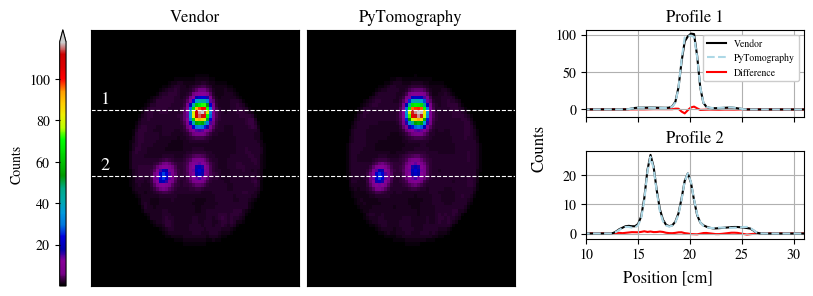

In [14]:
mode = 'color'
fig = plt.figure(constrained_layout=True, figsize=(8,2.85))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(1,0.55))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('Vendor')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_vendor, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object[0].cpu(), axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Counts', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=2, ncols=1, sharex=True)
plot_differences(axes_r[0],l1)
axes_r[0].set_title('Profile 1')
axes_r[0].legend(loc='upper right', facecolor='white', framealpha=1, frameon=True, fontsize=7)
plot_differences(axes_r[1],l2)
axes_r[1].set_title('Profile 2')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Counts')
plt.savefig('dicom_comparison_color.png', dpi=300)

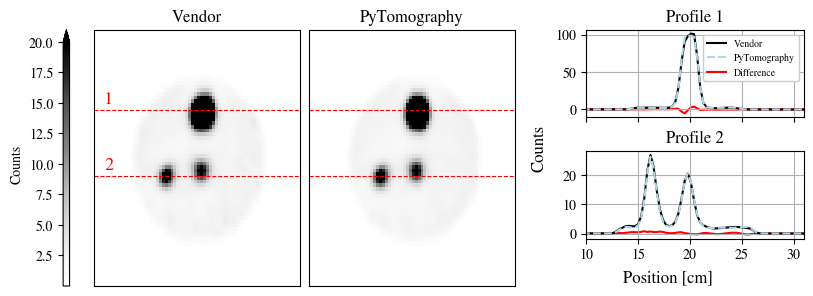

In [20]:
mode = 'bw'
fig = plt.figure(constrained_layout=True, figsize=(8,2.85))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(1,0.55))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('Vendor')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_vendor, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object[0].cpu(), axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Counts', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=2, ncols=1, sharex=True)
plot_differences(axes_r[0],l1)
axes_r[0].set_title('Profile 1')
axes_r[0].legend(loc='upper right', facecolor='white', framealpha=1, frameon=True, fontsize=7)
plot_differences(axes_r[1],l2)
axes_r[1].set_title('Profile 2')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Counts')
plt.savefig('images/figure5.jpg',bbox_inches='tight', dpi=300)

Get maximum percent difference, SSIM, and RMSE

* Max pct difference

In [17]:
r1 = reconstructed_object[0].cpu().numpy()
r2 = reconstructed_object_vendor
np.max((np.abs(r1-r2)/r1 * 100)[r1>10])

30.419406630615008

* SSIM

In [18]:
ssim = StructuralSimilarityIndexMeasure()
ssim(torch.tensor(r1).unsqueeze(0).unsqueeze(0), torch.tensor(r2).unsqueeze(0).unsqueeze(0)).item()

0.9997875690460205

* RMSE

In [19]:
np.sqrt(((r1 - r2) ** 2).mean())

0.11915731493667074